# Modelo predictivo para la estimación de casos positivos de influenza en EE.UU

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [2]:
#Apagar warnings
warnings.filterwarnings("ignore")

# Cargar los datos
file_path = "./dataset/Clinical_Labs_Clean.xlsx"

# Leer el Excel
df = pd.read_excel(file_path)

In [3]:
# Crear la serie de datos para la implementación de modelos
positive_influenza = df.set_index("DATE")["PERCENT POSITIVE"]
positive_influenza.sort_index(inplace=True)

In [4]:
# Número de semanas para pronosticar
n_forecast = 12

## Modelo: suavizamiento exponencial simple

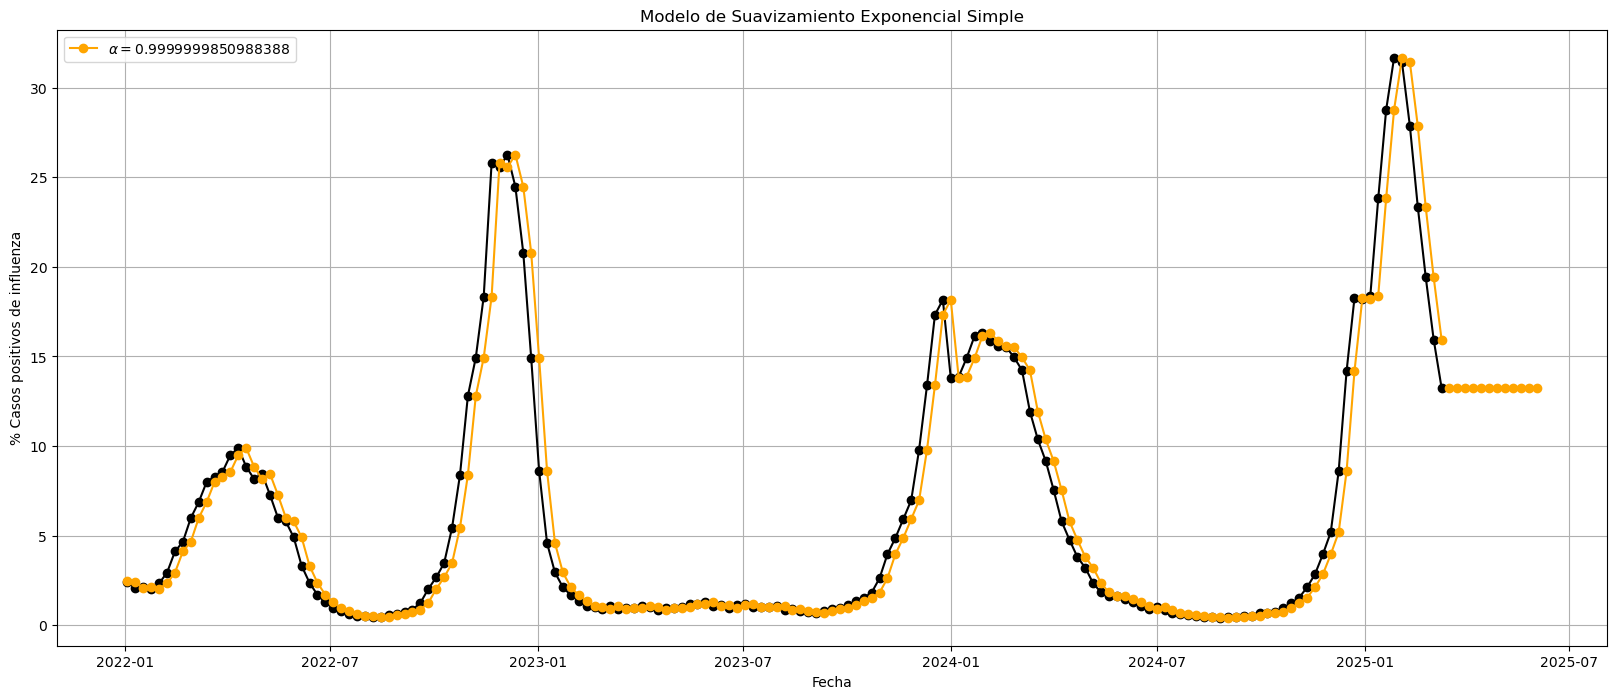

In [5]:
#Se delega la asignación de Nivel al modelo
ses_model = SimpleExpSmoothing(positive_influenza, initialization_method="estimated").fit(optimized=True)
ses_forecast = ses_model.forecast(n_forecast).rename(r"$\alpha=%s$" % ses_model.model.params["smoothing_level"])

plt.figure(figsize=(20, 8))
plt.plot(positive_influenza, marker="o", color="black")

plt.plot(ses_model.fittedvalues, marker="o", color="orange")
(ses_model_line,) = plt.plot(ses_forecast, marker="o", color="orange")

plt.legend([ses_model_line], [ses_forecast.name])
plt.title("Modelo de Suavizamiento Exponencial Simple")
plt.xlabel("Fecha")
plt.ylabel("% Casos positivos de influenza")
plt.grid(True)
plt.show() 

In [6]:
# Se extraen los parametros asignados por el modelo de suavizamiento exponencial
ses_model_params = pd.DataFrame(ses_model.params.items(), columns=['Parámetro', 'Valor'])
ses_model_params

,Parámetro,Valor
0,smoothing_level,1.0
1,smoothing_trend,NaN
2,smoothing_seasonal,NaN
3,damping_trend,NaN
4,initial_level,2.438558
5,initial_trend,NaN
6,initial_seasons,[]
7,use_boxcox,False
8,lamda,None
9,remove_bias,False


In [7]:
# Predicción obtenida del modelo SES
ses_forecast_values = pd.DataFrame({
    "Predicción #": range(1, n_forecast + 1),
    "Valor predicho": ses_forecast.values
})
ses_forecast_values.style.hide(axis="index")

Predicción #,Valor predicho
1,13.249800
2,13.249800
3,13.249800
4,13.249800
5,13.249800
6,13.249800
7,13.249800
8,13.249800
9,13.249800
10,13.249800


## Modelo: Holt

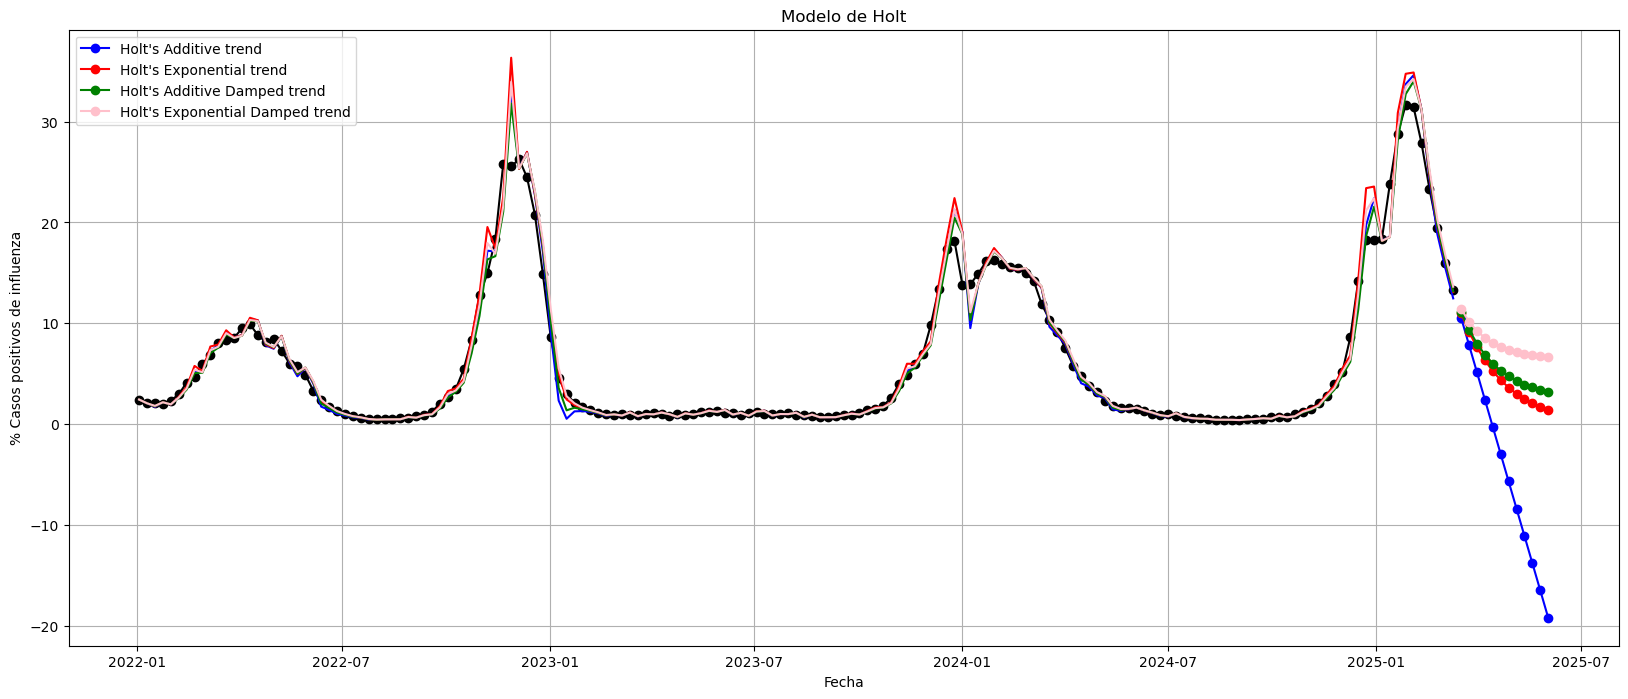

In [ ]:
# Metodo aditivo sin suavizamiento
holt_model_additive = Holt(positive_influenza, exponential=False, damped_trend=False, initialization_method="estimated").fit(optimized=True)
holt_forecast_additive = holt_model_additive.forecast(n_forecast).rename("Holt's Additive trend")

# Metodo exponencial sin suavizamiento
holt_model_exponential = Holt(positive_influenza, exponential=True, damped_trend=False, initialization_method="estimated").fit(optimized=True)
holt_forecast_exponential = holt_model_exponential.forecast(n_forecast).rename("Holt's Exponential trend")

# Modelo aditivo suavizado
holt_model_additive_dam = Holt(positive_influenza, exponential=False, damped_trend=True, initialization_method="estimated").fit(optimized=True)
holt_forecast_additive_dam = holt_model_additive_dam.forecast(n_forecast).rename("Holt's Additive Damped trend")

# Metodo exponencial y suavizamiento
holt_model_exponential_dam = Holt(positive_influenza, damped_trend=True, exponential=True, initialization_method="estimated").fit(optimized=True)
holt_forecast_exponential_dam = holt_model_exponential_dam.forecast(n_forecast).rename("Holt's Exponential Damped trend")


plt.figure(figsize=(20, 8))
plt.plot(positive_influenza, marker="o", color="black")

plt.plot(holt_model_additive.fittedvalues, color="blue")
(line1,) = plt.plot(holt_forecast_additive, marker="o", color="blue")

plt.plot(holt_model_exponential.fittedvalues, color="red")
(line2,) = plt.plot(holt_forecast_exponential, marker="o", color="red")

plt.plot(holt_model_additive_dam.fittedvalues, color="green")
(line3,) = plt.plot(holt_forecast_additive_dam, marker="o", color="green")

plt.plot(holt_model_exponential_dam.fittedvalues, color="pink")
(line4,) = plt.plot(holt_forecast_exponential_dam, marker="o", color="pink")

plt.legend([line1, line2, line3, line4], [holt_forecast_additive.name, holt_forecast_exponential.name, holt_forecast_additive_dam.name, holt_forecast_exponential_dam.name])
plt.title("Modelo de Holt")
plt.xlabel("Fecha")
plt.ylabel("% Casos positivos de influenza")
plt.grid(True)
plt.show() 


In [10]:
# Se extraen los parametros asignados por el modelo de Holt en sus distintas variaciones
params = [
    "smoothing_level", 
    "smoothing_trend", 
    "damping_trend", 
    "initial_level", 
    "initial_trend"
]

holt_params_table = pd.DataFrame(
    {
        "Additive": [holt_model_additive.params.get(p) for p in params],
        "Exponential": [holt_model_exponential.params.get(p) for p in params],
        "Additive Dam": [holt_model_additive_dam.params.get(p) for p in params],
        "Exponential Dam": [holt_model_exponential_dam.params.get(p) for p in params],
    },
    index=["α", "β", "ϕ", "L", "T"]
)
holt_params_table

,Additive,Exponential,Additive Dam,Exponential Dam
α,1.000000,1.000000,1.000000,1.000000
β,0.986854,1.000000,1.000000,1.000000
ϕ,NaN,NaN,0.800000,0.800000
L,2.800267,2.872279,2.898513,2.993429
T,-0.365094,0.847651,-0.579189,1.016885


In [11]:
# Predicción obtenida del modelo HOLT
holt_forecast_values = pd.DataFrame({
    "Predicción #": range(1, n_forecast + 1),
    "Additive": holt_forecast_additive.values,
    "Exponential": holt_forecast_exponential.values,
    "Additive Dam": holt_forecast_additive_dam.values,
    "Exponential Dam": holt_forecast_exponential_dam.values
})
holt_forecast_values.style.hide(axis="index")

Predicción #,Additive,Exponential,Additive Dam,Exponential Dam
1,10.545687,11.011139,11.094760,11.426354
2,7.841575,9.150718,9.370728,10.150007
3,5.137462,7.604631,7.991502,9.232372
4,2.433350,6.319767,6.888122,8.558366
5,-0.270763,5.251991,6.005418,8.054765
6,-2.974875,4.364625,5.299254,7.673306
7,-5.678988,3.627186,4.734323,7.381187
8,-8.383100,3.014344,4.282379,7.155520
9,-11.087213,2.505046,3.920823,6.979964
10,-13.791325,2.081798,3.631578,6.842625


## Modelo: Holt Winter

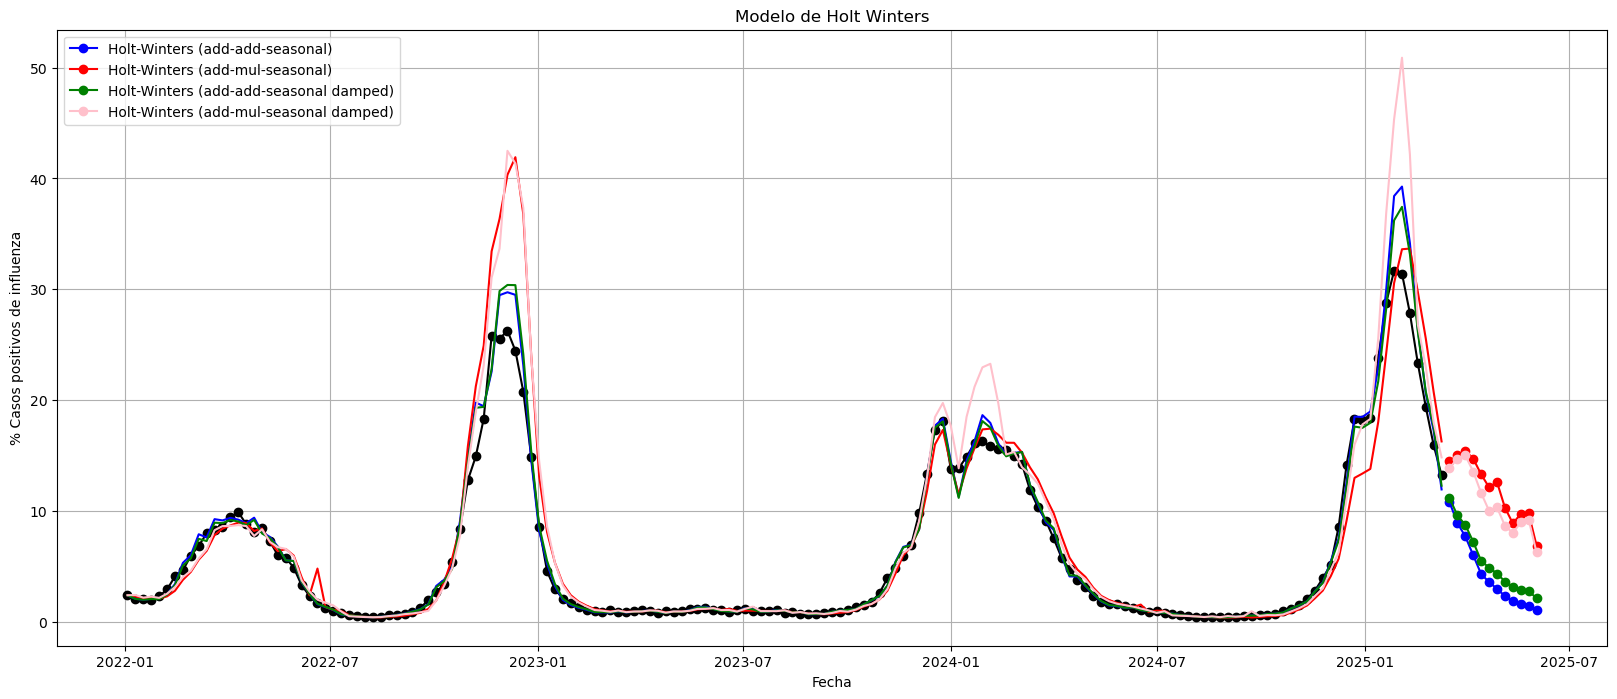

In [12]:
#Método aditivo sin suavizamiento
holtwinters_model_additive = ExponentialSmoothing(
    positive_influenza,
    seasonal_periods=52,
    trend="add",
    seasonal="add",
    damped_trend=False,
    use_boxcox=True,
    initialization_method="estimated",
).fit(optimized=True)
holtwinters_forecast_additive = holtwinters_model_additive.forecast(n_forecast).rename("Holt-Winters (add-add-seasonal)")

#Método multiplicativo sin suavizamiento
holtwinters_model_multiplicative = ExponentialSmoothing(
    positive_influenza,
    seasonal_periods=52,
    trend="add",
    seasonal="mul",
    damped_trend=False,
    use_boxcox=True,
    initialization_method="estimated",
).fit(optimized=True)
holtwinters_forecast_multiplicative = holtwinters_model_multiplicative.forecast(n_forecast).rename("Holt-Winters (add-mul-seasonal)")

#Método aditivo suavizado
holtwinters_model_additive_dam = ExponentialSmoothing(
    positive_influenza,
    seasonal_periods=52,
    trend="add",
    seasonal="add",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit(optimized=True)
holtwinters_forecast_additive_dam = holtwinters_model_additive_dam.forecast(n_forecast).rename("Holt-Winters (add-add-seasonal damped)")

#Método multiplicativo suavizado
holtwinters_model_multiplicative_dam = ExponentialSmoothing(
    positive_influenza,
    seasonal_periods=52,
    trend="add",
    seasonal="mul",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit(optimized=True)
holtwinters_forecast_multiplicative_dam = holtwinters_model_multiplicative_dam.forecast(n_forecast).rename("Holt-Winters (add-mul-seasonal damped)")


plt.figure(figsize=(20, 8))
plt.plot(positive_influenza, marker="o", color="black")

plt.plot(holtwinters_model_additive.fittedvalues, color="blue")
(line1,) = plt.plot(holtwinters_forecast_additive, marker="o", color="blue")

plt.plot(holtwinters_model_multiplicative.fittedvalues, color="red")
(line2,) = plt.plot(holtwinters_forecast_multiplicative, marker="o", color="red")

plt.plot(holtwinters_model_additive_dam.fittedvalues, color="green")
(line3,) = plt.plot(holtwinters_forecast_additive_dam, marker="o", color="green")

plt.plot(holtwinters_model_multiplicative_dam.fittedvalues, color="pink")
(line4,) = plt.plot(holtwinters_forecast_multiplicative_dam, marker="o", color="pink")

plt.legend([line1, line2, line3, line4], [holtwinters_forecast_additive.name, holtwinters_forecast_multiplicative.name, holtwinters_forecast_additive_dam.name, holtwinters_forecast_multiplicative_dam.name])
plt.title("Modelo de Holt Winters")
plt.xlabel("Fecha")
plt.ylabel("% Casos positivos de influenza")
plt.grid(True)
plt.show()


In [13]:
# Se extraen los parametros asignados por el modelo de Holt Winters en sus distintas variaciones

holtwinter_params_table = pd.DataFrame(
    {
        "Additive": [holtwinters_model_additive.params.get(p) for p in params],
        "Multiplicative": [holtwinters_model_multiplicative.params.get(p) for p in params],
        "Additive Dam": [holtwinters_model_additive_dam.params.get(p) for p in params],
        "Multiplicative Dam": [holtwinters_model_multiplicative_dam.params.get(p) for p in params],
    },
    index=["α", "β", "ϕ", "L", "T"]
)
holtwinter_params_table

,Additive,Multiplicative,Additive Dam,Multiplicative Dam
α,0.810823,0.770467,0.786422,1.000000e+00
β,0.713223,0.000006,0.786422,1.843057e-18
ϕ,NaN,NaN,0.882063,9.950000e-01
L,-0.266665,1.594233,-0.265789,8.798520e-02
T,0.017928,0.005617,0.028608,-1.410130e-04


In [14]:
# Predicción obtenida del modelo HOLT WINTERS
holtwinters_forecast_values = pd.DataFrame({
    "Predicción #": range(1, n_forecast + 1),
    "Additive": holtwinters_forecast_additive.values,
    "Multiplicative": holtwinters_forecast_multiplicative.values,
    "Additive Dam": holtwinters_forecast_additive_dam.values,
    "Multiplicative Dam": holtwinters_forecast_multiplicative_dam.values
})
holtwinters_forecast_values.style.hide(axis="index")

Predicción #,Additive,Multiplicative,Additive Dam,Multiplicative Dam
1,10.818509,14.489696,11.182324,13.901879
2,8.928921,15.039993,9.616640,14.725221
3,7.718206,15.465444,8.756418,15.018636
4,6.017596,14.725952,7.229597,13.564353
5,4.324500,13.314801,5.507059,11.627682
6,3.608706,12.146766,4.913356,10.032901
7,2.997140,12.627674,4.373301,10.338417
8,2.344574,10.320238,3.654423,8.694926
9,1.913351,8.899008,3.194407,8.020790
10,1.633499,9.740557,2.932384,8.986505


## Modelo: ARIMA

In [15]:
# Test de Dickey-Fuller para ver si la serie es estacionaria y determinar el valor de d
adf_result = adfuller(positive_influenza)

adf_arima_table = pd.Series(adf_result[0:4], index=[
    "Estadístico ADF",
    "p-valor",
    "# de rezagos usados",
    "# de observaciones usadas"
])

for key, value in adf_result[4].items():
    adf_arima_table[f"Valor crítico ({key})"] = value

adf_arima_table_df = adf_arima_table.to_frame(name="Resultado")
adf_arima_table_df.index.name = "Indicador"

adf_arima_table_df

,Resultado
Indicador,
Estadístico ADF,-4.040939
p-valor,0.001211
# de rezagos usados,1.000000
# de observaciones usadas,165.000000
Valor crítico (1%),-3.470616
Valor crítico (5%),-2.879221
Valor crítico (10%),-2.576197


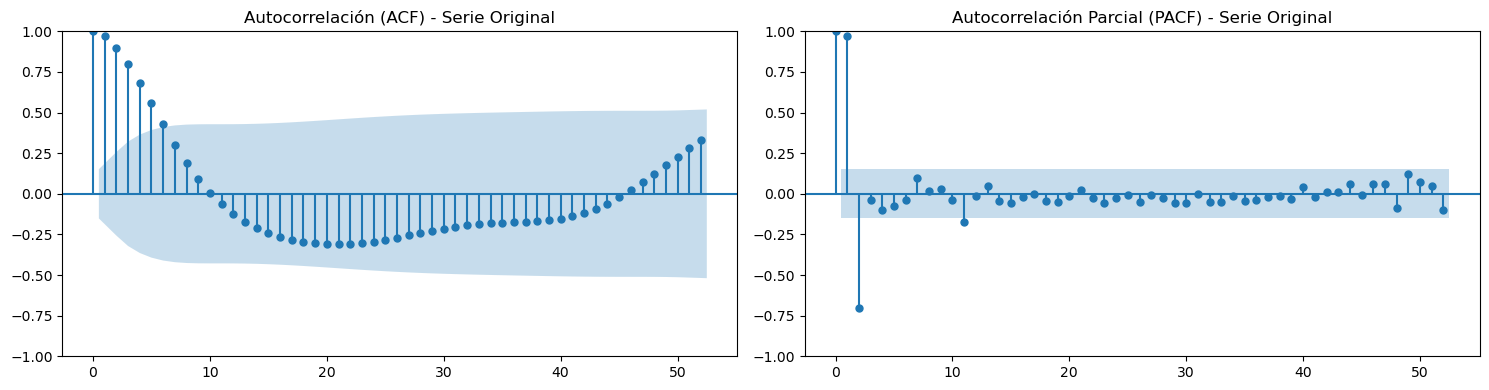

In [16]:
# Se grafica ACF y PACF de la serie original para determinar valores de p y q
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plot_acf(positive_influenza, lags=52, ax=plt.gca())
plt.title("Autocorrelación (ACF) - Serie Original")

plt.subplot(1, 2, 2)
plot_pacf(positive_influenza, lags=52, ax=plt.gca())
plt.title("Autocorrelación Parcial (PACF) - Serie Original")

plt.tight_layout()
plt.show()

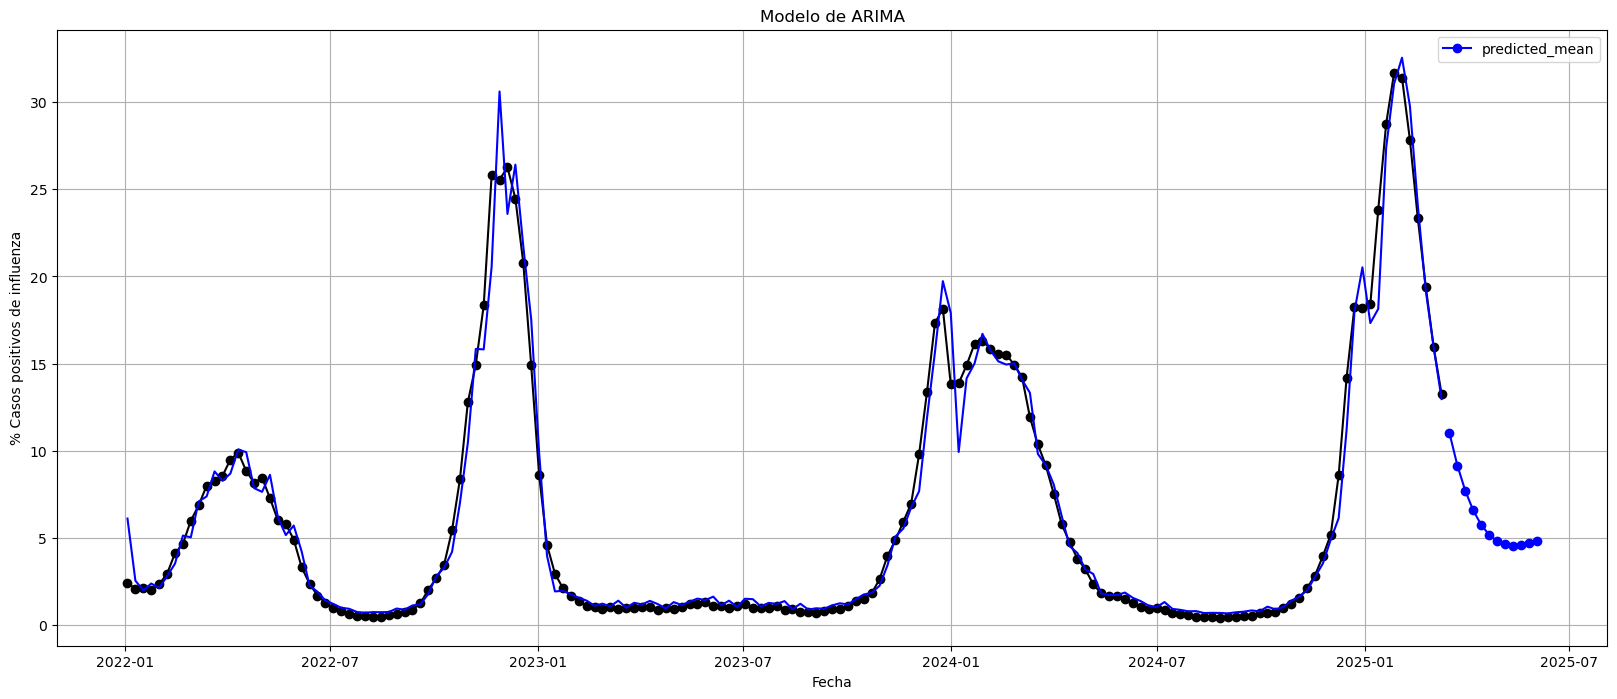

In [17]:
ma = [1,0,0,0,0,0,1]
ar = [1,0,1]

#order(p,d,q)
arima_model = ARIMA(positive_influenza, exog=None, order=(ar, 0, ma)).fit()
forecast_arima = arima_model.forecast(steps=n_forecast)

plt.figure(figsize=(20, 8))
plt.plot(positive_influenza, marker="o", color="black")

plt.plot(arima_model.fittedvalues, color="blue")
(line1,) = plt.plot(forecast_arima, marker="o", color="blue")

plt.legend([line1], [forecast_arima.name])
plt.title("Modelo de ARIMA")
plt.xlabel("Fecha")
plt.ylabel("% Casos positivos de influenza")
plt.grid(True)
plt.show()


In [18]:
# Se extraen los parametros asignados por el modelo ARIMA
arima_model_params = pd.DataFrame(arima_model.params.items(), columns=['Parámetro', 'Valor'])
arima_model_params

,Parámetro,Valor
0,const,6.106207
1,ar.L1,1.234841
2,ar.L3,-0.306346
3,ma.L1,0.547775
4,ma.L7,-0.009862
5,sigma2,1.309572


In [19]:
# Predicción obtenida del modelo ARIMA
arima_forecast_values = pd.DataFrame({
    "Predicción #": range(1, n_forecast + 1),
    "Valor predicho": forecast_arima.values
})
arima_forecast_values.style.hide(axis="index")

Predicción #,Valor predicho
1,11.000897
2,9.147994
3,7.693042
4,6.573617
5,5.749391
6,5.179504
7,4.815862
8,4.622145
9,4.557519
10,4.589115


# Modelo: SARIMA

In [20]:
# Aplicar una diferencia estacional con periodo 52
seasonal_diff = positive_influenza.diff(52).dropna()

# Test de Dickey-Fuller sobre la serie diferenciada estacionalmente
adf_seasonal_result = adfuller(seasonal_diff)

# Test de Dickey-Fuller
adf_sarima_table = pd.Series(adf_seasonal_result[0:4], index=[
    "Estadístico ADF",
    "p-valor",
    "# de rezagos usados",
    "# de observaciones usadas"
])

for key, value in adf_seasonal_result[4].items():
    adf_sarima_table[f"Valor crítico ({key})"] = value

adf_sarima_table = adf_sarima_table.to_frame(name="Resultado")
adf_sarima_table.index.name = "Indicador"

adf_sarima_table

,Resultado
Indicador,
Estadístico ADF,-3.705412
p-valor,0.004038
# de rezagos usados,1.000000
# de observaciones usadas,113.000000
Valor crítico (1%),-3.489590
Valor crítico (5%),-2.887477
Valor crítico (10%),-2.580604


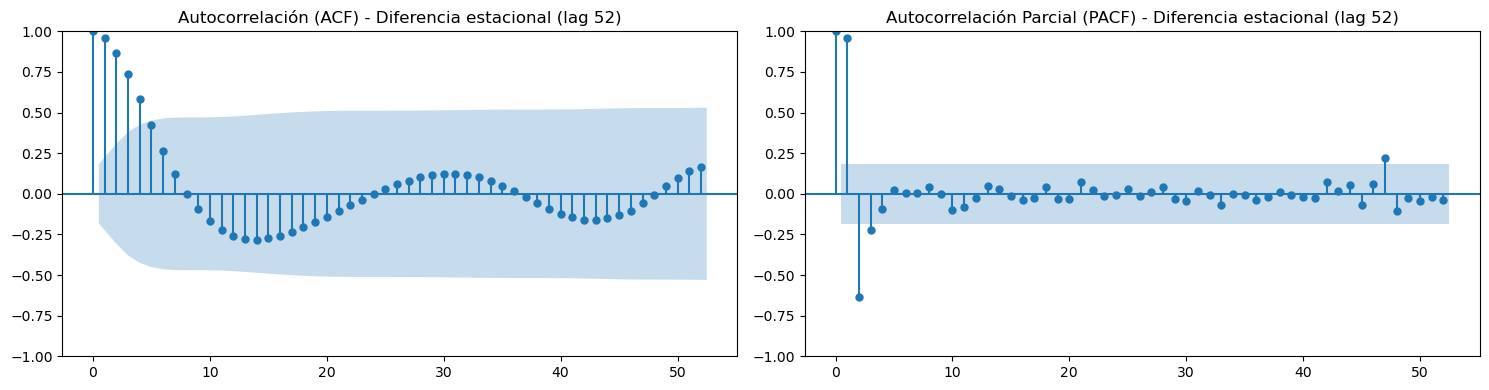

In [21]:
# Se grafica ACF y PACF de la serie diferenciada estacionalmente
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plot_acf(seasonal_diff, lags=52, ax=plt.gca())
plt.title("Autocorrelación (ACF) - Diferencia estacional (lag 52)")

plt.subplot(1, 2, 2)
plot_pacf(seasonal_diff, lags=52, ax=plt.gca())
plt.title("Autocorrelación Parcial (PACF) - Diferencia estacional (lag 52)")

plt.tight_layout()
plt.show()

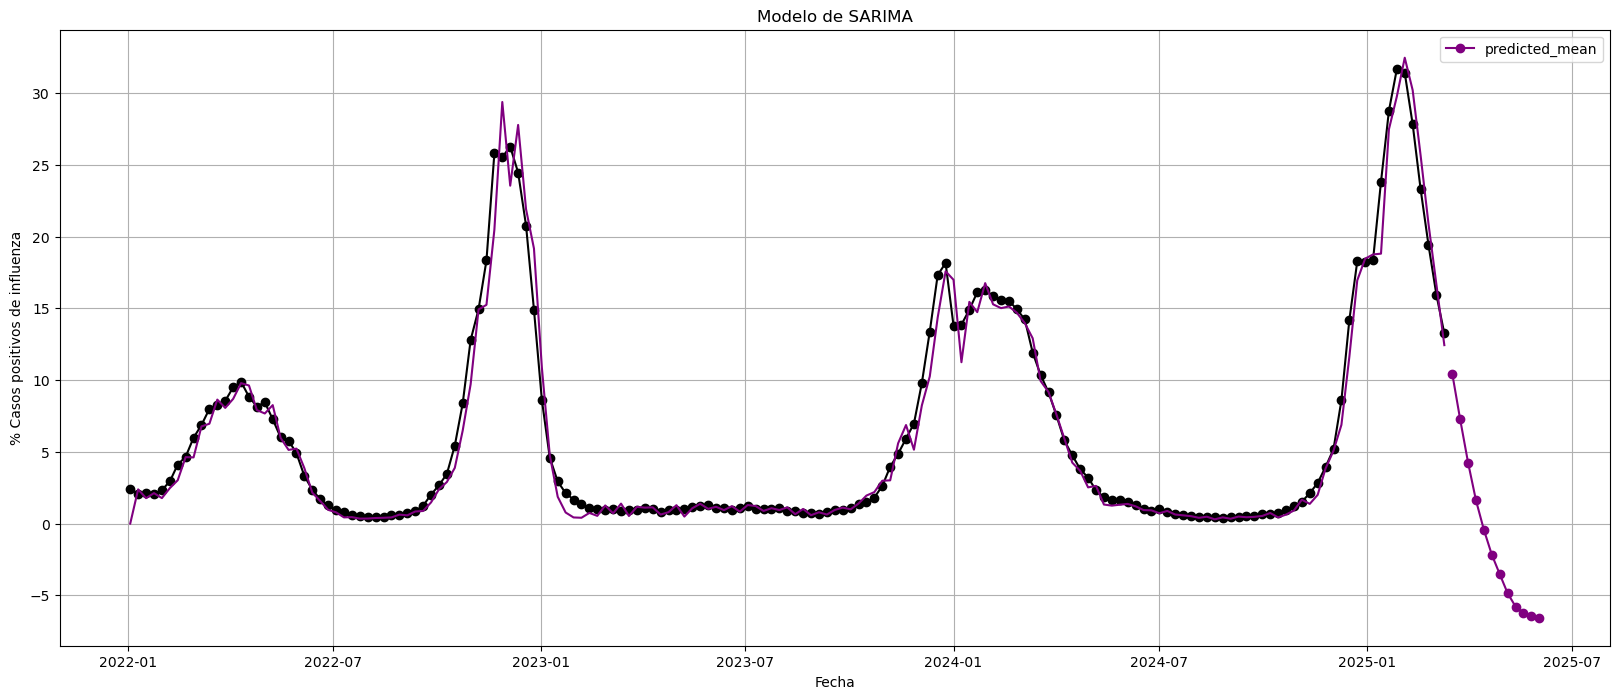

In [22]:
ma = [1,0,0,0,0,0,1]
ar = [1,0,1]

sarima_model = SARIMAX(positive_influenza, order=(ma, 0, ar), seasonal_order=(1, 0, 1, 52)).fit(disp=False)
forecast_sarima = sarima_model.forecast(steps=n_forecast)


plt.figure(figsize=(20, 8))
plt.plot(positive_influenza, marker="o", color="black")

plt.plot(sarima_model.fittedvalues, color="purple")
(line1,) = plt.plot(forecast_sarima, marker="o", color="purple")

plt.legend([line1], [forecast_sarima.name])
plt.title("Modelo de SARIMA")
plt.xlabel("Fecha")
plt.ylabel("% Casos positivos de influenza")
plt.grid(True)
plt.show()


In [23]:
# Se extraen los parametros asignados por el modelo SARIMA
sarima_model_params = pd.DataFrame(sarima_model.params.items(), columns=['Parámetro', 'Valor'])
sarima_model_params

,Parámetro,Valor
0,ar.L1,1.039301
1,ar.L7,-0.117593
2,ma.L1,0.584979
3,ma.L3,0.000756
4,ar.S.L52,-0.013601
5,ma.S.L52,0.399207
6,sigma2,1.336770


In [24]:
# Predicción obtenida del modelo SARIMA
sarima_forecast_values = pd.DataFrame({
    "Predicción #": range(1, n_forecast + 1),
    "Valor predicho": forecast_sarima.values
})
sarima_forecast_values.style.hide(axis="index")

Predicción #,Valor predicho
1,10.458538
2,7.264078
3,4.248855
4,1.612847
5,-0.439687
6,-2.172008
7,-3.527830
8,-4.861729
9,-5.785670
10,-6.250595


## Desempeño de modelos

In [ ]:
model_forecasts = {
    "Suav. Exp. Simple": ses_model.fittedvalues,

    "Modelo Holt Aditivo": holt_model_additive.fittedvalues,
    "Modelo Holt Exponencial": holt_model_exponential.fittedvalues,
    "Modelo Holt Aditivo Dam": holt_model_additive_dam.fittedvalues,
    "Modelo Holt Exponencial Dam": holt_model_exponential_dam.fittedvalues,

    "Modelo Winters Aditivo": holtwinters_model_additive.fittedvalues,
    "Modelo Winters Multiplicativo": holtwinters_model_multiplicative.fittedvalues,
    "Modelo Winters Aditivo Dam": holtwinters_model_additive_dam.fittedvalues,
    "Modelo Winters Multiplicativo Dam": holtwinters_model_multiplicative_dam.fittedvalues,

    "ARIMA": arima_model.fittedvalues,
    "SARIMA": sarima_model.fittedvalues
}

# Calcular y mostrar las métricas de error para cada modelo
print("Métricas de error (usando MAE como MAD):")
print(f"{'Modelo':40s} {'MAD':>10s} {'MAPE (%)':>12s} {'TS min':>10s} {'TS max':>10s} {'Desv. Est.':>14s}")
print("-" * 100)

for model_name, forecast in model_forecasts.items():
    actual = positive_influenza.loc[forecast.index]
    
    # Errores
    et = actual - forecast
    at = np.abs(et)

    # Métricas
    mad = mean_absolute_error(actual, forecast)
    mape = mean_absolute_percentage_error(actual, forecast) * 100
    std_dev = np.std(et)

    # Tracking Signal acumulado
    ts = np.cumsum(et) / np.cumsum(at)
    ts_min = np.min(ts)
    ts_max = np.max(ts)

    print(f"{model_name:40s} {mad:10.2f} {mape:12.2f} {ts_min:10.2f} {ts_max:10.2f} {std_dev:14.2f}")


Métricas de error (usando MAE como MAD):
Modelo                                          MAD     MAPE (%)     TS min     TS max     Desv. Est.
----------------------------------------------------------------------------------------------------
Suav. Exp. Simple                              0.97        16.54      -1.00       0.89           1.75
Modelo Holt Aditivo                            0.66        12.32      -1.00       1.00           1.30
Modelo Holt Exponencial                        0.68        10.93      -0.48       1.00           1.48
Modelo Holt Aditivo Dam                        0.63        11.09      -0.08       1.00           1.21
Modelo Holt Exponencial Dam                    0.64        10.26      -0.34       1.00           1.30
Modelo Winters Aditivo                         0.59         8.03      -0.61       1.00           1.30
Modelo Winters Multiplicativo                  1.38        18.65      -0.95       1.00           2.98
Modelo Winters Aditivo Dam                